In [1]:
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

from collections import Counter
from functools import reduce
from string import punctuation
from bs4 import BeautifulSoup

import os
import requests
import re
import numpy as np
import pandas as pd

pd.options.display.max_columns = 10
pd.options.mode.chained_assignment = None
os.chdir('/Users/ernestng/Desktop/projects/foodreview/amazon-fine-food-reviews/')

In [2]:
fooddf = pd.read_csv("./Reviews.csv") #Reading amazon fine food review data
fooddf = fooddf[['Score', 'Text']]

Check counts of each rating(1-5)

In [3]:
fooddf.groupby('Score').count()

Text
Score        
1       52268
2       29769
3       42640
4       80655
5      363122

We see that there is a significantly larger number of reviews with rating of 5, so I plan to use random under sampling to balance the data.

Random Under sampling aims to balance class distribution by randomly eliminating majority class examples. This is done until the majority and minority class instances are balanced out. In this approach, I reduce the data from higher class (data with 4 and 5 rating) to match the data with lower class(data with 1 and 2 rating).

I can eliminate data with 3 rating since I want to create a binary classifer and rating 3 is really sitting on the fence, although we can keep in mind rating 3 might be useful for multiclass classifier

counts of rating 1-2 : 82037
counts of rating 4-5 : 443777 (I will randomly pick 82037 data points from here)

In [4]:
food_low = fooddf[fooddf['Score']<3]
food_low.head()

Score                                               Text
1       1  Product arrived labeled as Jumbo Salted Peanut...
3       2  If you are looking for the secret ingredient i...
12      1  My cats have been happily eating Felidae Plati...
16      2  I love eating them and they are good for watch...
26      1  The candy is just red , No flavor . Just  plan...

In [5]:
food_high = fooddf[fooddf['Score']>3]
food_high.head()
food_high_resampled = food_high.sample(n = 82037, random_state=12)

In [6]:
new_food = pd.concat([food_low,food_high_resampled])
def sentiment(x):
    if x < 3:
        return 0
    else:
        return 1
new_food["sentiment"] = new_food.Score.map(sentiment)
new_food.sentiment.value_counts()

1    82037
0    82037
Name: sentiment, dtype: int64

In [7]:
new_food

Score                                               Text  sentiment
1           1  Product arrived labeled as Jumbo Salted Peanut...          0
3           2  If you are looking for the secret ingredient i...          0
12          1  My cats have been happily eating Felidae Plati...          0
16          2  I love eating them and they are good for watch...          0
26          1  The candy is just red , No flavor . Just  plan...          0
...       ...                                                ...        ...
410093      5  Loved this for breakfast as a child.  My child...          1
217854      5  After a lengthy trek in the Himalayan Range, t...          1
426527      5  These wafers are wonderfully light and taste j...          1
395540      5  I'm a huge fan of Earnest Eats with my favorit...          1
167235      5  My dogs are all on very limited ingredient die...          1

[164074 rows x 3 columns]

X input : Text
y output : sentiment

In [8]:
X_train, X_test, y_train, y_test = train_test_split(new_food.Text, new_food.sentiment, test_size=0.1, random_state=42)


After splitting the data, I use CountVectorizer() to convert text documents to matrix of token counts. 

This configuration tokenize the strings and convert them to lower case and build a vocabulary of comma separated tokens.

In [9]:
xvect = CountVectorizer().fit(X_train)
xtrain_vect = xvect.transform(X_train)

This data is further processed by applying Tfidf Vectorizer, which helps us to give more weightage to important words which less important words for the case study would be given more weights.
Since, our code is based on counting the frequency of each word in the document, so if certain words like ‘the’, ‘if’ etc. which are present more frequently then words which are more important such as ‘buy’,’product’ etc. , which gives us the context.

In [10]:
xvect = TfidfVectorizer().fit(X_train)
xtrain_vect = xvect.transform(X_train)
len(xvect.get_feature_names())

66953

I further improve my model, for example it would help us to differentiate between ‘good’ and ‘not good’ as it would take both words together(for bi gram count pairs). Also, it would help us to work with more features. I have set the n-grams in the range of 1–2 which helps us to extract features for 1 and 2 grams.

In [11]:
xvect = TfidfVectorizer(ngram_range = (1,3)).fit(X_train)
xtrain_vect = xvect.transform(X_train)
len(xvect.get_feature_names())

6002749

To fit this model, I am going to use Logistic Regression and Multinomial Naive Bayes Algorithm and I will compare both the models.

Multinomial NB

In [12]:
food_model = MultinomialNB()
food_model.fit(xtrain_vect, y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [13]:
predictions = food_model.predict(xvect.transform(X_test))
roc_auc_score(y_test, predictions)

0.9350965745754435

Logistic Regression

Parameters I changed: 
1) multi_class='ovr' (Binary problem is fit for each label)
2) n_jobs=1 (Number of CPU cores used when parallelizing over classes if multi_class=’ovr’)
3) solver='liblinear' (Algorithm to use when optimizing over a small dataset such as this)

In [14]:
food_LRmodel = LogisticRegression(n_jobs=1,multi_class='ovr',solver='liblinear')
food_LRmodel.fit(xtrain_vect, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [15]:
predictionsLR = food_LRmodel.predict(xvect.transform(X_test))
roc_auc_score(y_test, predictionsLR)

0.9358109760522249

Logistic Regression(LR) gives us a better AUC score than Multinomial NB(MNB). 
LR gives better prediction than MNB, hence I will the LR model

Function to determine review input

In [16]:
def predictreview(x):
    rev = food_LRmodel.predict(xvect.transform(x))
    rev_list = np.where(rev==1,"Positive","Negative").tolist()
    return rev_list

Test cases

In [17]:
test = ["the ayam penyet i had today was awesome!",
         "good plate of fried rice, but expensive",
        "portion too small",
        "great value for money!",
        "cheap and good food",
        "cheap food",
        "waste of money",
        "terrible service and the food is badly done",
        "edible but i will not visit again",
       "wonderful service, i will definitely visit again",
       "not very good"]

test_chinese = ["hen haochi", 
                "hen bu haochi", 
                "shiwu bu hao chi",
                "wo bu xi huan shiwu",
                "wo xi huan shiwu"]
predictreview(test)

['Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Negative']

I included some hanyupinyin to test if my model can understand chinese words

In [18]:
predictreview(test_chinese)

['Positive', 'Negative', 'Negative', 'Negative', 'Positive']

Confusion matrix looks good, number of true positives and true negatives are quite even 

In [19]:
confusion_matrix(y_test, predictionsLR)

array([[7743,  479],
       [ 574, 7612]])

The recall_score tells us intuitively the ability of the classifier to find all the positive samples.

Conclusion: This model is trained against Amazon Fine Food Dataset with 164074 reviews after cleaning the data. We have achieved an accuracy score of around 93.57% which is quite good. I believe when I train this model against a larger dataset, I can achieve a much higher accuracy.


# Now we will retrieve some food reviews about places in Singapore and apply sentiment analysis on them

In [20]:
location_class = "lemon--a__373c0__IEZFH link__373c0__1G70M link-color--inherit__373c0__3dzpk link-size--inherit__373c0__1VFlE"
num_class = 'lemon--div__373c0__1mboc u-padding-b2 border-color--default__373c0__2oFDT text-align--center__373c0__1l506'
review_class = 'lemon--p__373c0__3Qnnj text__373c0__2pB8f comment__373c0__3EKjH text-color--normal__373c0__K_MKN text-align--left__373c0__2pnx_'

I define these functions to retrieve the top 90 possible locations from the main URL

In [21]:
#enter country to search here
country_of_interest = 'singapore'
main_url = 'https://www.yelp.com/search?find_desc=&find_loc={}'.format(country_of_interest)
session = requests.Session()

def getLocs(url):
    #main = 'https://www.yelp.com/search?find_desc=&find_loc=singapore&ns=1'
    request = session.get(url)
    soup = BeautifulSoup(request.content,'html.parser')
    search_results = soup.findAll("a",{"class":location_class})
    loc_urls = []
    
    for s in search_results:
        if s.get_text().isdigit():
            continue
        else:
            loc_urls.append(s['href'])
            
    return loc_urls

def getPages(url):
    request = session.get(url)
    soup = BeautifulSoup(request.content,'html.parser')
    search_results = soup.findAll("a",{"class":location_class})
    pages_urls = []
    
    for s in search_results:
        if s.get_text().isdigit():
            pages_urls.append(s['href'])
        else:
            continue
            
    return pages_urls

def crawlPage(main_url):
    all_loc_urls = []
    r_page_urls = []
    base_url = 'https://www.yelp.com'
    print("Scraping",main_url,"...")
    all_loc_urls += getLocs(main_url)
    r_page_urls += getPages(main_url)
    
    for page in r_page_urls:
        current = base_url + page
        print("Scraping",current,"...")
        all_loc_urls += getLocs(current)
        
    n = len(all_loc_urls)
    print("Scraped", n,"possible locations!")
    
    return all_loc_urls

new_locs = crawlPage(main_url)
#new_locs

Scraping https://www.yelp.com/search?find_desc=&find_loc=singapore ...
Scraping https://www.yelp.com/search?find_loc=singapore&start=10 ...
Scraping https://www.yelp.com/search?find_loc=singapore&start=20 ...
Scraping https://www.yelp.com/search?find_loc=singapore&start=30 ...
Scraping https://www.yelp.com/search?find_loc=singapore&start=40 ...
Scraping https://www.yelp.com/search?find_loc=singapore&start=50 ...
Scraping https://www.yelp.com/search?find_loc=singapore&start=60 ...
Scraping https://www.yelp.com/search?find_loc=singapore&start=70 ...
Scraping https://www.yelp.com/search?find_loc=singapore&start=80 ...
Scraped 90 possible locations!


Here are functions to retrieve information in a single page

In [22]:
def getReviews(url):
    request = session.get(url)
    soup = BeautifulSoup(request.content,'html.parser')
    search_results = soup.findAll("p",{"class":review_class}) #get reviews
    revs = []
    for s in search_results:
        revs.append(s.get_text())
    return revs
    
def numPages(url):
    request = session.get(url)
    soup = BeautifulSoup(request.content,'html.parser')
    search_results = soup.find("div",{"class":num_class})
    
    page_res = search_results.get_text()
    return int(page_res.split(" ")[-1])

This are my functions to clean and tokenize the reviews 

In [23]:
stop_words = []

f = open('/Users/ernestng/Desktop/projects/webscrap/stopwords.txt', 'r')
for l in f.readlines():
    stop_words.append(l.replace('\n', ''))
    
additional_stop_words = ['a','pm','tian','will','sooo']
stop_words += additional_stop_words

def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

def tokenizer(text):
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop_words + list(punctuation)) , tokens))
    return tokens

This function will crawl through each page and retrieve the names of every restaurant, as well as their reviews.

In [24]:
def crawlReviews(loc_lists):
    base_url = 'https://www.yelp.com'
    reviews = []
    place_name = []
    for loc in loc_lists:
        rev = []
        current_url = base_url + loc
        #get location name 
        pattern = "/biz/(.*?)-singapore"
        placename = re.search(pattern, loc).group(1)
        totalPages = numPages(current_url)
        if totalPages == 1:
            print("crawling",  placename,"Page 1...")
            rev += getReviews(current_url)
        else:
            mult = totalPages * 20
            start = 20
            print("crawling",  placename,"Page 1...")
            rev += getReviews(current_url)
            while start != mult:
                page_ext = '?start={}'.format(start)
                print("crawling",  placename,"Page", start//20 + 1, "...")
                rev += getReviews(current_url + page_ext)
                start += 20
        #print("Getting info on", placename, "...")
        
        n = len(rev)
        reviews += rev
        place_name += [placename] * n
        #print("Retrieved", n, "reviews!")
        
    reviews = list(map(clean_text,reviews))
    sentiment = predictreview(reviews)
    print(len(reviews),len(place_name))
    loc_dict = {"Place":place_name, "Reviews": reviews, "Sentiment": sentiment}
    
    loc_df = pd.DataFrame(data = loc_dict)
    #i import my results into a csv file for easy accessibility in the future
    try:
        loc_df.to_csv('/Users/ernestng/Desktop/projects/foodreview/yelpreviews.csv', encoding='utf-8', index=False)
    except:
        loc_df.to_csv('/Users/ernestng/Desktop/projects/foodreview/yelpreviews.csv', index=False, encoding='utf-8')
    return loc_df

In [25]:
crawlReviews(new_locs)

crawling gardens-by-the-bay Page 1...
crawling gardens-by-the-bay Page 2 ...
crawling gardens-by-the-bay Page 3 ...
crawling gardens-by-the-bay Page 4 ...
crawling gardens-by-the-bay Page 5 ...
crawling gardens-by-the-bay Page 6 ...
crawling gardens-by-the-bay Page 7 ...
crawling gardens-by-the-bay Page 8 ...
crawling gardens-by-the-bay Page 9 ...
crawling gardens-by-the-bay Page 10 ...
crawling gardens-by-the-bay Page 11 ...
crawling gardens-by-the-bay Page 12 ...
crawling gardens-by-the-bay Page 13 ...
crawling gardens-by-the-bay Page 14 ...
crawling gardens-by-the-bay Page 15 ...
crawling gardens-by-the-bay Page 16 ...
crawling gardens-by-the-bay Page 17 ...
crawling gardens-by-the-bay Page 18 ...
crawling tian-tian-hainanese-chicken-rice Page 1...
crawling tian-tian-hainanese-chicken-rice Page 2 ...
crawling tian-tian-hainanese-chicken-rice Page 3 ...
crawling tian-tian-hainanese-chicken-rice Page 4 ...
crawling tian-tian-hainanese-chicken-rice Page 5 ...
crawling tian-tian-hainane

crawling swee-choon-tim-sum Page 3 ...
crawling swee-choon-tim-sum Page 4 ...
crawling corner-house Page 1...
crawling corner-house Page 2 ...
crawling hainanese-delicacy-chicken-rice Page 1...
crawling hainanese-delicacy-chicken-rice Page 2 ...
crawling the-auld-alliance Page 1...
crawling the-auld-alliance Page 2 ...
crawling bar-stories Page 1...
crawling bar-stories Page 2 ...
crawling bar-stories Page 3 ...
crawling s-e-a-aquarium Page 1...
crawling s-e-a-aquarium Page 2 ...
crawling straitskitchen Page 1...
crawling straitskitchen Page 2 ...
crawling straitskitchen Page 3 ...
crawling long-beach-seafood Page 1...
crawling long-beach-seafood Page 2 ...
crawling long-beach-seafood Page 3 ...
crawling long-beach-seafood Page 4 ...
crawling chinatown Page 1...
crawling chinatown Page 2 ...
crawling chinatown Page 3 ...
crawling the-good-beer-company Page 1...
crawling the-good-beer-company Page 2 ...
crawling taste-paradise Page 1...
crawling taste-paradise Page 2 ...
crawling maison

Place  \
0        gardens-by-the-bay   
1        gardens-by-the-bay   
2        gardens-by-the-bay   
3        gardens-by-the-bay   
4        gardens-by-the-bay   
...                     ...   
5622  lao-ban-soya-beancurd   
5623  lao-ban-soya-beancurd   
5624  lao-ban-soya-beancurd   
5625  lao-ban-soya-beancurd   
5626  lao-ban-soya-beancurd   

                                                Reviews Sentiment  
0     went with my girlfriend to gardens by the bay ...  Positive  
1     review is solely for the gardens an iconic lan...  Positive  
2     it is nice to see it by day to see the structu...  Positive  
3     expect to be mesmerized by this enchanting gar...  Positive  
4     wow all i can say is wow this place is amazing...  Positive  
...                                                 ...       ...  
5622  this is probably the best beancurd you can get...  Positive  
5623  look it is a bird it is a plane no it is a gia...  Negative  
5624  a must try a local favorite hot spot for this ...  Positive  
5625  located along old airport road this humble sta...  Negative  
5626  as a person addicted to sugar highs i usually ...  Positive  

[5627 rows x 3 columns]

In [26]:
yelp_data = pd.read_csv('/Users/ernestng/Desktop/projects/foodreview/yelpreviews.csv')
yelp_data

Place  \
0        gardens-by-the-bay   
1        gardens-by-the-bay   
2        gardens-by-the-bay   
3        gardens-by-the-bay   
4        gardens-by-the-bay   
...                     ...   
5622  lao-ban-soya-beancurd   
5623  lao-ban-soya-beancurd   
5624  lao-ban-soya-beancurd   
5625  lao-ban-soya-beancurd   
5626  lao-ban-soya-beancurd   

                                                Reviews Sentiment  
0     went with my girlfriend to gardens by the bay ...  Positive  
1     review is solely for the gardens an iconic lan...  Positive  
2     it is nice to see it by day to see the structu...  Positive  
3     expect to be mesmerized by this enchanting gar...  Positive  
4     wow all i can say is wow this place is amazing...  Positive  
...                                                 ...       ...  
5622  this is probably the best beancurd you can get...  Positive  
5623  look it is a bird it is a plane no it is a gia...  Negative  
5624  a must try a local favorite hot spot for this ...  Positive  
5625  located along old airport road this humble sta...  Negative  
5626  as a person addicted to sugar highs i usually ...  Positive  

[5627 rows x 3 columns]

# Data exploration

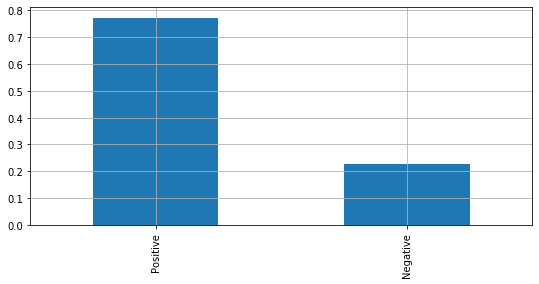

In [27]:
yelp_data.Sentiment.value_counts(normalize=True).plot(kind='bar', grid=True, figsize=(9, 4))


From the distribution table above, we see that there are more positive reviews than negative ones which tells us that the food in Singapore generally leave a good impression on consumers.

In [28]:
#Get unique reviews only
yelp_data = yelp_data.drop_duplicates('Reviews')
#Remove empty reviews
yelp_data = yelp_data[~yelp_data['Reviews'].isnull()]
#A tweet's length is 140 characters. By past experience in NLP has shown me that any sentences with lesser than
#140 characters tend to introduce lots of noise. Hence I will remove any reviews with <140 characters.
yelp_data = yelp_data[(yelp_data.Reviews.map(len) > 140)]
yelp_data.reset_index(inplace=True, drop=True)

In [29]:
print(yelp_data.shape) #I removed a total of 426 reviews

(5194, 3)


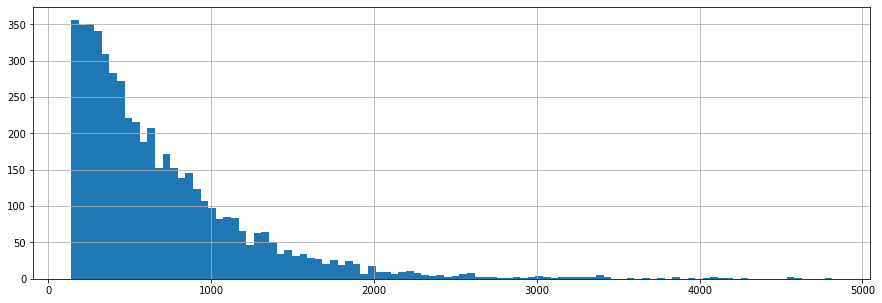

In [30]:
yelp_data.Reviews.map(len).hist(figsize=(15, 5), bins=100)

In [31]:
yelp_data['tokens'] = list(map(tokenizer,yelp_data['Reviews']))
yelp_data.head()

Place                                            Reviews  \
0  gardens-by-the-bay  went with my girlfriend to gardens by the bay ...   
1  gardens-by-the-bay  review is solely for the gardens an iconic lan...   
2  gardens-by-the-bay  it is nice to see it by day to see the structu...   
3  gardens-by-the-bay  expect to be mesmerized by this enchanting gar...   
4  gardens-by-the-bay  wow all i can say is wow this place is amazing...   

  Sentiment                                             tokens  
0  Positive  [girlfriend, gardens, bay, managed, clock, ste...  
1  Positive  [review, solely, gardens, iconic, landmark, si...  
2  Positive  [nice, day, structure, assembled, full, beauty...  
3  Positive  [expect, mesmerized, enchanting, garden, leavi...  
4  Positive  [wow, wow, place, amazing, ginormous, lots, se...

In [32]:
def keywords(category):
    tokens = yelp_data[yelp_data['Sentiment'] == category]['tokens']
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(20)

for sent in set(yelp_data['Sentiment']):
    print('Sent :', sent)
    print('top 10 keywords:', keywords(sent))

Sent : Positive
top 10 keywords: [('good', 2530), ('singapore', 2528), ('place', 2244), ('food', 2172), ('chicken', 1575), ('great', 1385), ('rice', 1273), ('time', 1196), ('well', 1145), ('best', 1095), ('crab', 963), ('service', 898), ('definitely', 852), ('sauce', 827), ('delicious', 823), ('coffee', 771), ('long', 766), ('nice', 739), ('restaurant', 725), ('pork', 700)]
Sent : Negative
top 10 keywords: [('food', 741), ('place', 695), ('chicken', 672), ('singapore', 652), ('good', 628), ('rice', 433), ('time', 400), ('crab', 344), ('service', 320), ('ordered', 299), ('pretty', 268), ('order', 266), ('better', 264), ('people', 255), ('long', 248), ('restaurant', 242), ('well', 240), ('soup', 233), ('experience', 230), ('sauce', 224)]


In [33]:
vectorizer = TfidfVectorizer(min_df = 5, analyzer='word', ngram_range=(1, 2), stop_words='english')
vz = vectorizer.fit_transform(list(yelp_data['tokens'].map(lambda tokens: ' '.join(tokens))))

print(vz.shape)

(5194, 9403)


In [34]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In this plot, we will see generic words that are commonly found in the reviews. These words are assigned a lower weightable since they do not tell us much about the reviews.

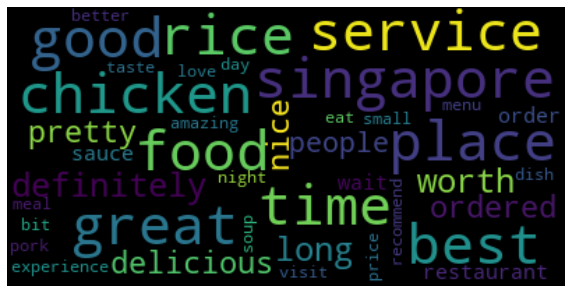

In [36]:
plot_word_cloud(tfidf.sort_values(by = ['tfidf'], ascending = True).head(40))

In constrast, these are the words which are assigned higher weightages because they are unique and gives us an underlying sense of what the reviews are about.

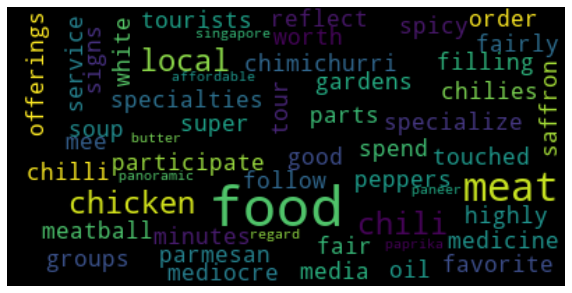

In [37]:
plot_word_cloud(tfidf.sort_values(by = ['tfidf'], ascending = False).head(40))

In [38]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=0)
svd_tfidf = svd.fit_transform(vz)

print(svd_tfidf.shape)

(5194, 50)


In [39]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)
print(tsne_tfidf.shape)
tsne_tfidf_df = pd.DataFrame(tsne_tfidf)
tsne_tfidf_df.columns = ['x', 'y']
tsne_tfidf_df['category'] = yelp_data['Sentiment']
tsne_tfidf_df['description'] = yelp_data['Reviews']
tsne_tfidf_df.to_csv('/Users/ernestng/Desktop/projects/foodreview/tsid.csv', encoding='utf-8', index=False)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5194 samples in 0.011s...
[t-SNE] Computed neighbors for 5194 samples in 1.836s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5194
[t-SNE] Computed conditional probabilities for sample 2000 / 5194
[t-SNE] Computed conditional probabilities for sample 3000 / 5194
[t-SNE] Computed conditional probabilities for sample 4000 / 5194
[t-SNE] Computed conditional probabilities for sample 5000 / 5194
[t-SNE] Computed conditional probabilities for sample 5194 / 5194
[t-SNE] Mean sigma: 0.092286
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.454231
[t-SNE] KL divergence after 500 iterations: 1.507736
(5194, 2)


In [40]:
tsne_tfidf_df.head()

x          y  category  \
0 -27.650988  31.258322  Positive   
1 -21.369074  25.641375  Positive   
2 -25.642439  31.119068  Positive   
3  -2.202734  11.398203  Positive   
4 -14.436884  24.889139  Positive   

                                         description  
0  went with my girlfriend to gardens by the bay ...  
1  review is solely for the gardens an iconic lan...  
2  it is nice to see it by day to see the structu...  
3  expect to be mesmerized by this enchanting gar...  
4  wow all i can say is wow this place is amazing...

In [41]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.io import save, output_file

output_notebook()
plot_tfidf = bp.figure(plot_width = 700, plot_height = 600, title = "TF-IDF Clustering of the reviews",
    tools = "pan,wheel_zoom,box_zoom,reset,hover,save",
    x_axis_type = None, y_axis_type = None, min_border = 1)

palette = d3['Category10'][len(tsne_tfidf_df['category'].unique()) + 1]
color_map = bmo.CategoricalColorMapper(factors = tsne_tfidf_df['category'].map(str).unique(), palette=palette)

plot_tfidf.scatter(x = 'x', y = 'y', color={'field': 'category', 'transform': color_map}, 
                   legend_group= 'category', source = tsne_tfidf_df)
hover = plot_tfidf.select(dict(type = HoverTool))
hover.tooltips = {"description": "@description", "category":"@category"}

show(plot_tfidf)

Loading BokehJS ...

In the bokeh plot, each cluster is determined by the variety of unique words commonly used in the reviews. Reviews that are clustered together tend to contain the same unique words and hence, are grouped together. 

In this project, I have trained my sentiment analysis model on Amazon Fine Food reviews and found the accuracy to be approximately 93.8%. Following, I webscraped information on the top 90 places to eat in Singapore and have done data exploration on the dataset.